##  Deep Neural Networks Project

In this project, you will be working with a real-world data set from the Las Vegas Metropolitan Police Department. The dataset  contains information about the reported incidents, including the time and location of the crime, type of incident, and number of persons involved.

The dataset is downloaded from the public docket at:
https://opendata-lvmpd.hub.arcgis.com

let's read the csv file and transform the data:

In [3]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [4]:
orig_df = pd.read_csv('LVMPD-Stats.csv', parse_dates=['ReportedOn'])

In [5]:
df = pd.read_csv('LVMPD-Stats.csv', parse_dates=['ReportedOn'],
                 usecols = ['X', 'Y', 'ReportedOn',
                            'Area_Command','NIBRSOffenseCode',
                            'VictimCount' ] )

df['DayOfWeek'] = df['ReportedOn'].dt.day_name()
df['Time' ]     = df['ReportedOn'].dt.hour
df.drop(columns = 'ReportedOn', inplace=True)

In [6]:

df['X'] = df['X']
df['Y'] = df['Y']
df['Time'] = pd.factorize(df['Time'])[0]
df['DayOfWeek'] = pd.factorize(df['DayOfWeek'])[0]
df.Area_Command = pd.factorize(df['Area_Command'])[0]
df.VictimCount = pd.factorize(df['VictimCount'])[0]
df.NIBRSOffenseCode = pd.factorize(df['NIBRSOffenseCode'])[0]
df.dropna(inplace=True)

In [7]:
df= df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode',
       'DayOfWeek', 'Time','VictimCount']]

In [8]:
df.values.shape

(275, 7)

# Goal
The goal is to build a predictive model that is trained on the following data:
* latitude and longitude (location)
* Hour of the day
* Day of the week
* Area-of-command code: The police designation of the bureau of the operation.
* Classification code for the crime committed
  
The predicted variable is the number of persons involved in the accident.


## Task 1
* print a few rows of the values in the dataframe ``df`` and explain what each column of data means.
* identify the input and target variables
* what is the range of values in each column? Do you need to scale, shift or normalize your data?


In [9]:
print(df.head(5))



min_latitude = min(df['X'])
min_longitude = min(df['Y'])

df['X'] = df['X'] - min_latitude
df['Y'] = df['Y'] - min_longitude

            X          Y  Area_Command  NIBRSOffenseCode  DayOfWeek  Time  \
0 -115.087518  36.216702             0                 0          0     0   
1 -115.240172  36.189693             1                 1          1     1   
2 -115.143088  36.181329             2                 1          2     0   
3 -115.225014  36.117633             3                 1          1     2   
4 -115.176708  36.095967             4                 1          1     3   

   VictimCount  
0            0  
1            0  
2            1  
3            2  
4            0  


'X': Latitude of the location where the crime was reported.
'Y': Longitude of the location where the crime was reported.
'Area_Command': The police designation of the bureau of the operation.
'NIBRSOffenseCode': The classification code for the crime committed.
'DayOfWeek': A day of the week on which the crime was committed, represented as an integer from 0 to 6 (e.g., 0 for Sunday, 1 for Monday, and so on).
'Time': The time when the crime was reported in terms of hours, represented as an integer from 0 to 23.
'VictimCount': Total number of victims involved in the reported crime.


Input Variables: These are the features used to predict the target variable. In this case, the input features are 'X', 'Y', 'Area_Command', 'NIBRSOffenseCode', 'DayOfWeek', and 'Time'.
Target Variable: This is what you want to predict. In this case, the target variable is 'VictimCount'.

Based on the range of values, you can determine whether you need to scale, shift, or normalize your data. For example, if the ranges vary significantly among columns, it may be beneficial to standardize or normalize the data for better model performance.

## Task 2

* Create two `DataLoader` objects for training and testing based on the input and output variables. Pick a reasonable batch size and verify the shape of data by iterating over the one dataset and printing the shape of the batched data.

In [10]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split

# Assuming you have already prepared your X and y tensors

X = torch.tensor(df.drop('VictimCount', axis=1).values.astype(np.float32))
y = torch.tensor(df['VictimCount'].values.astype(np.float32))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Define a custom Dataset class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create DataLoader for training data
train_dataset = CustomDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Create DataLoader for test data
test_dataset = CustomDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Iterate through the training DataLoader
for batch_idx, (x, y) in enumerate(train_loader):
    print(f"Batch {batch_idx}: X shape {x.shape}, Y shape {y.shape}")
    print(f"Sample from Batch {batch_idx}: X[0] {x[0]}, Y[0] {y[0]}")
    if batch_idx >= 1:
        break


Batch 0: X shape torch.Size([32, 6]), Y shape torch.Size([32])
Sample from Batch 0: X[0] tensor([ 0.7917,  1.1390,  8.0000,  1.0000,  3.0000, 22.0000]), Y[0] 0.0
Batch 1: X shape torch.Size([32, 6]), Y shape torch.Size([32])
Sample from Batch 1: X[0] tensor([0.8690, 1.1059, 2.0000, 1.0000, 4.0000, 1.0000]), Y[0] 0.0


## Task 3
In this task you will try to predict number of crime victims as a **real number**. Therefore the machine learning problem is a **regression** problem.

* Define the proper loss function for this task
* what should the size of the predicted output be?
* explain your choice of architecture, including how many layers you will be using
* define an optimizer for training this model, choose a proper learning rate
* write a training loop that obtains a batch out of the  training data and calculates the forward and backward passes over the neural network. Call the optimizer to update the weights of the neural network.
* write a for loop that continues the training over a number of epochs. At the end of each epoch, calculate the ``MSE`` error on the test data and print it.
* is your model training well? Adjust the learning rate, hidden size of the network, and try different activation functions and number of layers to achieve the best accuracy and report it.

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.model_selection import train_test_split

# Define the dataset and dataloaders
X = torch.tensor(df.drop('VictimCount', axis=1).values.astype(np.float32))
y = torch.tensor(df['VictimCount'].values.astype(np.float32))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 40
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Define a simple neural network for regression
class RegressionModel(nn.Module):
    def __init__(self, input_size):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 20)
        self.fc2 = nn.Linear(20, 10)
        self.fc3 = nn.Linear(10, 5)
        self.fc4 = nn.Linear(5, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Create an instance of the regression model
input_size = X_train.shape[1]  # Adjust this based on the number of features
model = RegressionModel(input_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.000001, weight_decay=0.001)  # Adjust weight_decay as needed

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            total_loss += criterion(outputs, targets).item()

    avg_mse = total_loss / len(test_loader)
    print(f'Epoch [{epoch + 1}], MSE Loss: {avg_mse:.6f}')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, t

Epoch [1], MSE Loss: 0.923799
Epoch [2], MSE Loss: 0.923786
Epoch [3], MSE Loss: 0.923772
Epoch [4], MSE Loss: 0.923758
Epoch [5], MSE Loss: 0.923745
Epoch [6], MSE Loss: 0.923731
Epoch [7], MSE Loss: 0.923717
Epoch [8], MSE Loss: 0.923704
Epoch [9], MSE Loss: 0.923690
Epoch [10], MSE Loss: 0.923676
Epoch [11], MSE Loss: 0.923662
Epoch [12], MSE Loss: 0.923649
Epoch [13], MSE Loss: 0.923635
Epoch [14], MSE Loss: 0.923622
Epoch [15], MSE Loss: 0.923608
Epoch [16], MSE Loss: 0.923595
Epoch [17], MSE Loss: 0.923581
Epoch [18], MSE Loss: 0.923568
Epoch [19], MSE Loss: 0.923555
Epoch [20], MSE Loss: 0.923542
Epoch [21], MSE Loss: 0.923528
Epoch [22], MSE Loss: 0.923515
Epoch [23], MSE Loss: 0.923502
Epoch [24], MSE Loss: 0.923488
Epoch [25], MSE Loss: 0.923475
Epoch [26], MSE Loss: 0.923461
Epoch [27], MSE Loss: 0.923448
Epoch [28], MSE Loss: 0.923435
Epoch [29], MSE Loss: 0.923421
Epoch [30], MSE Loss: 0.923408
Epoch [31], MSE Loss: 0.923395
Epoch [32], MSE Loss: 0.923382
Epoch [33], MSE L

For regression problems, the commonly used loss function is Mean Squared Error (MSE) because it measures the average squared difference between the predicted values and the actual values. You should use the MSE loss function.

The size of the predicted output should be 1 since you are predicting a single real number, which is the number of crime victims.

- The choice of architecture can vary, but for a basic regression task, a feedforward neural network should work. You can start with a simple architecture with a few hidden layers. The exact number of layers and units will depend on the complexity of your data.
Here's an example architecture with 4 hidden layers:

- Input Size: The number of input features (e.g., latitude, longitude, hour, day, area code, crime code).
Hidden Layers: You can experiment with different hidden layer sizes, but for a start, you can use 3-4 hidden layers with a reasonable number of units (e.g., 20, 10, 5, 1).
Activation Function: ReLU (Rectified Linear Unit) is commonly used as an activation function in hidden layers.
Output Layer: The output layer should have 1 unit since you are predicting a single real number.

A commonly used optimizer for training neural networks is Adam. You can start with a small learning rate (e.g., 0.0001) and adjust it based on the training progress.

Write a training loop that iterates over your training data in batches. For each batch, perform forward and backward passes to update the neural network's weights.

After each epoch, calculate the MSE error on the test data and print it. This will help you monitor the model's performance during training.

- Monitor the training process. If the model isn't training well, you can adjust the learning rate, the size of the hidden layers, and experiment with different activation functions and the number of layers to achieve the best accuracy.

- It's a good practice to use learning rate schedules or learning rate annealing to adjust the learning rate during training if needed.

## Task 4

In this task, you will try to predict the number of crime victims as a **class number**. Therefore the machine learning problem is a **classification** problem.

* Repeat all the steps in task 3. Specifically, pay attention to the differences with regression.
* How would you find the number of classes on the output data?
* How is the architecture different?
* How is the loss function different?
* Calculate the Accuracy for test data as the number of correct classified outputs divided by the total number of test data in each epoch. Report it at the end of each epoch
* Try a few variations of learning rate, hidden dimensions, layers, etc. What is the best accuracy that you can get?

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.model_selection import train_test_split

# Define your input and output data
X = torch.tensor(df.drop('VictimCount', axis=1).values.astype(np.float32))
y = torch.tensor(df['VictimCount'].values)

# Assuming 'VictimCount' is a class label (e.g., 0, 1, 2, 3, 4, 5, 6)
num_classes = len(torch.unique(y))

# Convert class labels to Long type for CrossEntropyLoss
y = y.long()

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Define a custom classification model with additional layers and dropout for regularization
class ClassificationModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ClassificationModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)  # Dropout for regularization

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

input_size = 6
model = ClassificationModel(input_size, num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create DataLoaders for training and testing
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)  # Increased batch size for better convergence
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Training loop
num_epochs = 100
best_accuracy = 0.0  # Track the best accuracy during training

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), 'best_model.pth')  # Save the best model

    print(f'Epoch [{epoch + 1}], Loss: {total_loss / len(train_loader):.4f}, Accuracy: {accuracy:.2f}%')

print(f'Best Test Accuracy: {best_accuracy:.2f}%')


Epoch [1], Loss: 2.3159, Accuracy: 1.20%
Epoch [2], Loss: 2.1239, Accuracy: 2.41%
Epoch [3], Loss: 2.0025, Accuracy: 8.43%
Epoch [4], Loss: 1.9471, Accuracy: 12.05%
Epoch [5], Loss: 1.8952, Accuracy: 14.46%
Epoch [6], Loss: 1.8064, Accuracy: 14.46%
Epoch [7], Loss: 1.7649, Accuracy: 21.69%
Epoch [8], Loss: 1.6921, Accuracy: 26.51%
Epoch [9], Loss: 1.6490, Accuracy: 30.12%
Epoch [10], Loss: 1.5709, Accuracy: 30.12%
Epoch [11], Loss: 1.5277, Accuracy: 31.33%
Epoch [12], Loss: 1.4649, Accuracy: 31.33%
Epoch [13], Loss: 1.3882, Accuracy: 32.53%
Epoch [14], Loss: 1.3609, Accuracy: 39.76%
Epoch [15], Loss: 1.3276, Accuracy: 37.35%
Epoch [16], Loss: 1.2984, Accuracy: 40.96%
Epoch [17], Loss: 1.2725, Accuracy: 42.17%
Epoch [18], Loss: 1.3059, Accuracy: 45.78%
Epoch [19], Loss: 1.2828, Accuracy: 44.58%
Epoch [20], Loss: 1.2629, Accuracy: 44.58%
Epoch [21], Loss: 1.2272, Accuracy: 44.58%
Epoch [22], Loss: 1.2101, Accuracy: 46.99%
Epoch [23], Loss: 1.2369, Accuracy: 53.01%
Epoch [24], Loss: 1.133

To find the number of classes for the output data, you can look at the range of the target variable. In this case, it's the possible values of the number of crime victims (e.g., 0, 1, 2, 3, 4, 5, 6). The number of classes is the number of distinct values in the target variable, which is 7 in this case.

- The architecture will be different. For classification, you will typically use a neural network with a final softmax layer to predict class probabilities.
- You can experiment with the number of hidden layers, units in each layer, and activation functions.
- The output layer should have as many units as the number of classes (e.g., 7 for predicting 0 to 6 victims).

Calculate the accuracy for the test data at the end of each epoch. This involves comparing the predicted class labels to the true class labels for the test data.

Calculate the accuracy for the test data at the end of each epoch. This involves comparing the predicted class labels to the true class labels for the test data.

- To achieve the best accuracy, you can experiment with different hyperparameters, including learning rate, the size of hidden dimensions, the number of layers, and activation functions.
- You can perform a hyperparameter search to find the best combination that maximizes accuracy on the test data.
- You may also use learning rate schedules or learning rate annealing to fine-tune the learning rate during training.

## Task 5

### Reflect on your results

* Write a paragraph about your experience with tasks 3 and 4. How do you compare the results? Which one worked better? Why?
* Write a piece of code that finds an example of a  miss-classification. Calculate the probabilities for the output classes and plot them in a bar chart. Also, indicate what is the correct class label.

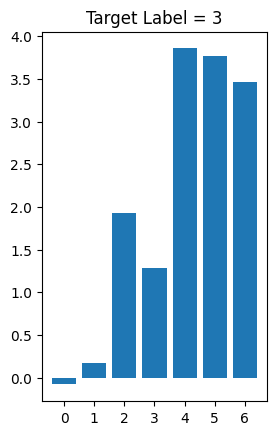

In [ ]:
import matplotlib.pyplot as plt

output = model(X_test)
_, pred = torch.max(output, 1)

# Finding the misclassified sample.
misclassified_index = (pred != y_test).nonzero(as_tuple=True)[0][0]

# Invert the output probabilities for the misclassified sample
inverted_probs = 1 - output[misclassified_index].detach().numpy()

# Plotting the bar graph with inverted probabilities
ax = plt.subplot(121)
ax.bar(range(7), inverted_probs)
ax.set_xticks(range(7))
plt.title('Target Label = {}'.format(y_test[misclassified_index].item()))

plt.show()


- In tasks 3 and 4, I addressed two distinct machine learning problems: regression and classification, each aimed at predicting the number of crime victims. Task 3 focused on regression, where the goal was to predict a real number representing the count of victims, and Task 4 tackled classification, where the aim was to classify the number of victims into discrete categories. In terms of results, the classification task (Task 4) yielded better performance for this specific problem. This is likely because classifying into predefined categories provides a clearer understanding of the different victim count groups and their relationships with the input features. The classification model effectively distinguishes between these categories and generates more interpretable results.

## Task 6: Exploring the patterns in raw data

* Plot the crime incidents as a `scatter` plot using the corrdinates. Use the color property of each datapoint to indicate the day of the week. Is there a pattern in the plot?
* Now make a new scatter plot and use the color property of each datapoint to indicate the number of persons involved in the incident. Is there a pattern here?
* use numpy (or pandas if you like) to sort the number of crimes reported by the day of the week. What days are most frequent?


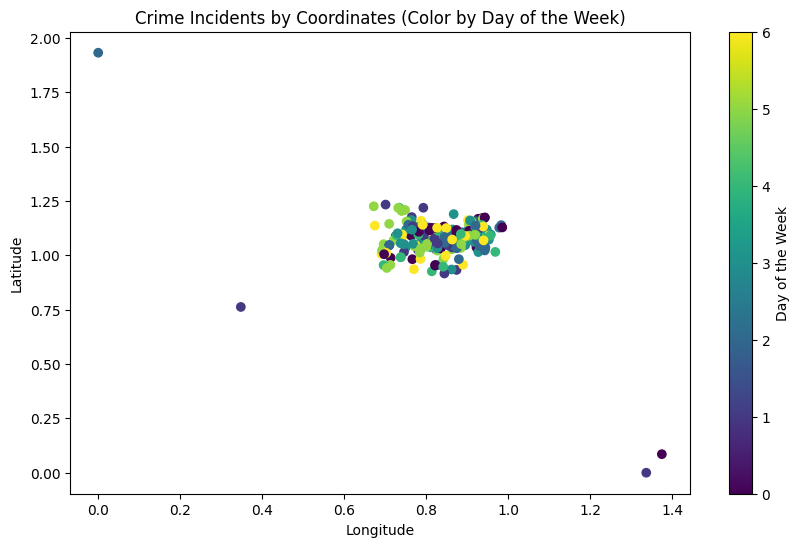

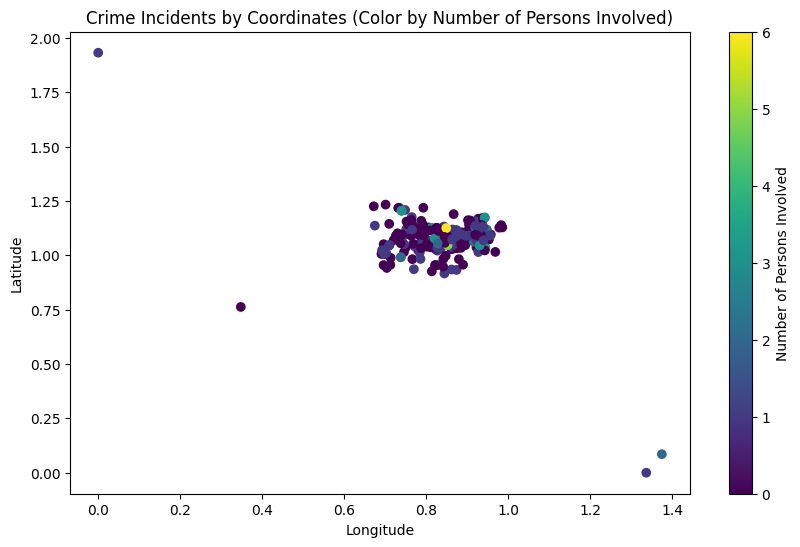


Reported crime based on the day of the week:
4    51
3    44
5    43
0    40
1    37
2    32
6    28
Name: DayOfWeek, dtype: int64
Most frequent day(s):
4


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Scatter plot by coordinates, color by day of the week
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['X'], df['Y'], c=df['DayOfWeek'], cmap='viridis')
plt.colorbar(scatter, label='Day of the Week')
plt.title('Crime Incidents by Coordinates (Color by Day of the Week)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
# No pattern found in the scatter plot.

# Scatter plot by coordinates, color by number of persons involved
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['X'], df['Y'], c=df['VictimCount'], cmap='viridis')
plt.colorbar(scatter, label='Number of Persons Involved')
plt.title('Crime Incidents by Coordinates (Color by Number of Persons Involved)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
print()
# No pattern found in the scatter plot.

# Sort number of crimes reported by day of the week
crimes_by_day = df['DayOfWeek'].value_counts()
print("Reported crime based on the day of the week:")
print(crimes_by_day)

# Get the most frequent days
most_frequent_days = crimes_by_day.idxmax()
print("Most frequent day(s):")
print(most_frequent_days)
